In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (194).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(52).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (189).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (186).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (2).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (95).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(14).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (190).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (283).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(101).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (45).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark (292).png
/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset/Dark/dark-(76).png
/kaggle/input/coffee-bean-dataset/Coffee Bean

In [2]:
import os

# List all datasets added to your notebook
print(os.listdir("/kaggle/input"))

['coffee-bean-dataset']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import itertools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

2025-08-25 02:06:19.555336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756087579.727234      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756087579.779868      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_dir = "/kaggle/input/coffee-bean-dataset/Coffee Bean Dataset"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# define your mapping
class_dict = {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

train_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    classes=list(class_dict.keys())  # enforce custom class order
)

val_gen = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    classes=list(class_dict.keys())  # keep same mapping
)

num_classes = len(train_gen.class_indices)

print("Class indices:", train_gen.class_indices)


Found 1280 images belonging to 4 classes.
Found 320 images belonging to 4 classes.
Class indices: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [5]:
from tensorflow.keras import layers, models, Input
import tensorflow as tf

def cbam_block(feature_map, ratio=8):
    channel = feature_map.shape[-1]

    # Channel Attention
    shared_dense_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = layers.GlobalAveragePooling2D()(feature_map)
    avg_pool = layers.Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_dense_one(avg_pool)
    avg_pool = shared_dense_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(feature_map)
    max_pool = layers.Reshape((1,1,channel))(max_pool)
    max_pool = shared_dense_one(max_pool)
    max_pool = shared_dense_two(max_pool)

    channel_attention = layers.Add()([avg_pool, max_pool])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([feature_map, channel_attention])

    # Spatial Attention
    avg_pool_sp = layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool_sp = layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=3)([avg_pool_sp, max_pool_sp])
    spatial_attention = layers.Conv2D(1, (7,7), padding='same', activation='sigmoid')(concat)

    refined_feature = layers.Multiply()([channel_refined, spatial_attention])
    return refined_feature


def build_cbam_cnn(input_shape=(128,128,3), num_classes=None):
    if num_classes is None:
        raise ValueError("Please pass num_classes from your train_gen.class_indices length")

    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = cbam_block(x)

    # Global Average Pooling + Dense
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [6]:
# Build CBAM Model with correct number of classes
cbam_model = build_cbam_cnn(
    input_shape=(128,128,3), 
    num_classes=num_classes  # comes from train_gen.class_indices
)

# Compile the model
cbam_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = cbam_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)


I0000 00:00:1756087592.035210      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756087601.155715      74 service.cc:148] XLA service 0x78d3cc05ca70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756087601.156647      74 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756087602.021229      74 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/40 ━━━━━━━━━━━━━━━━━━━━ 8:20 13s/step - accuracy: 0.3750 - loss: 1.3862

I0000 00:00:1756087607.051212      74 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 417ms/step - accuracy: 0.2628 - loss: 1.3866 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.2355 - loss: 1.3864 - val_accuracy: 0.2500 - val_loss: 1.3805
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.3029 - loss: 1.2632 - val_accuracy: 0.7406 - val_loss: 0.6135
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.6942 - loss: 0.6673 - val_accuracy: 0.7312 - val_loss: 0.5854
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.7927 - loss: 0.5079 - val_accuracy: 0.8375 - val_loss: 0.3761
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.8389 - loss: 0.4003 - val_accuracy: 0.9438 - val_loss: 0.2307
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9350 - loss: 0.2261 - val_accuracy: 0.9500 - val_loss: 0.1600
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.9307 - loss: 0.1979 - val_accuracy: 0.893

In [7]:
# --- Step 1: Reuse trained CBAM CNN (do NOT retrain) ---
# Assuming cbam_model is already trained above

# --- Step 2: Create feature extractor model (remove softmax output) ---
feature_extractor = models.Model(
    inputs=cbam_model.input,
    outputs=cbam_model.layers[-3].output   # Dense(256) before Dropout
)

# --- Step 3: Extract features from train & val sets ---
X_train = feature_extractor.predict(train_gen, verbose=1)
y_train = train_gen.classes

X_val = feature_extractor.predict(val_gen, verbose=1)
y_val = val_gen.classes

# --- Step 4: Train + Evaluate ML classifiers ---
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("\n🔹 Random Forest Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf, target_names=list(train_gen.class_indices.keys())))

# SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_val)
print("\n🔹 SVM Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm, target_names=list(train_gen.class_indices.keys())))

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)
print("\n🔹 KNN Results:")
print("Accuracy:", accuracy_score(y_val, y_pred_knn))
print(classification_report(y_val, y_pred_knn, target_names=list(train_gen.class_indices.keys())))


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step

🔹 Random Forest Results:
Accuracy: 0.28125
              precision    recall  f1-score   support

        Dark       0.28      0.30      0.29        80
       Green       0.36      0.39      0.37        80
       Light       0.32      0.29      0.30        80
      Medium       0.16      0.15      0.16        80

    accuracy                           0.28       320
   macro avg       0.28      0.28      0.28       320
weighted avg       0.28      0.28      0.28       320


🔹 SVM Results:
Accuracy: 0.409375
              precision    recall  f1-score   support

        Dark       0.17      0.16      0.17        80
       Green       0.87      0.97      0.92        80
       Light       0.67      0.50      0.57        80
      Medium       0.00      0.00      0.00        80

    accuracy                           0.41       320
   macro avg       0.43      0.41      0.41       320
weighted avg       0.43 

Fold 1 - Accuracy: 0.2436, AUC: 0.4832
Fold 2 - Accuracy: 0.2553, AUC: 0.5029
Fold 3 - Accuracy: 0.2606, AUC: 0.5048
Mean Accuracy: 0.25313080669811217
Mean AUC: 0.4969461993326865

🔹 Validation Set Results
Accuracy: 0.35625
Precision: 0.3565529956773004
Recall: 0.35624999999999996
F1-score: 0.35624063744091017
Confusion Matrix:
 [[27 17 12 24]
 [28 30 12 10]
 [ 8 17 35 20]
 [23 15 20 22]]


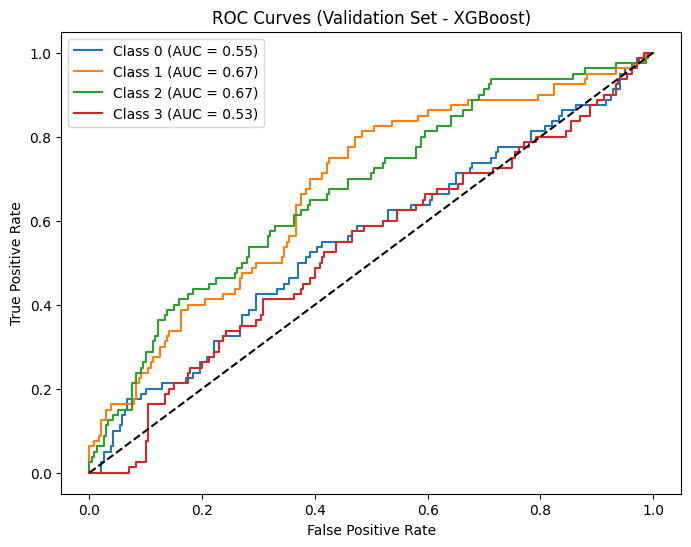

In [8]:
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# --- Scale features (important for ML models) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# --- Stratified K-Fold for robust evaluation ---
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
fold = 1
acc_list, auc_list = [], []

for train_idx, test_idx in kf.split(X_train_scaled, y_train):
    X_tr, X_te = X_train_scaled[train_idx], X_train_scaled[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    # Train XGBoost
    xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
    xgb.fit(X_tr, y_tr)

    # Predictions
    y_pred = xgb.predict(X_te)
    y_proba = xgb.predict_proba(X_te)

    # Accuracy
    acc = accuracy_score(y_te, y_pred)
    acc_list.append(acc)

    # ROC-AUC (only if all classes present in fold)
    unique_classes = np.unique(y_train)
    y_te_bin = label_binarize(y_te, classes=unique_classes)

    if y_te_bin.shape[1] < num_classes:
        print(f"Fold {fold} - Accuracy: {acc:.4f}, ROC-AUC skipped")
        auc_list.append(np.nan)
    else:
        auc_score = roc_auc_score(y_te_bin, y_proba, multi_class='ovr')
        auc_list.append(auc_score)
        print(f"Fold {fold} - Accuracy: {acc:.4f}, AUC: {auc_score:.4f}")

    fold += 1

print("Mean Accuracy:", np.nanmean(acc_list))
print("Mean AUC:", np.nanmean(auc_list))


# --- Validation Set Evaluation ---
y_val_pred = xgb.predict(X_val_scaled)
y_val_proba = xgb.predict_proba(X_val_scaled)

print("\n🔹 Validation Set Results")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
print("Recall:", recall_score(y_val, y_val_pred, average='macro'))
print("F1-score:", f1_score(y_val, y_val_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# ROC Curves (if all classes present)
y_val_bin = label_binarize(y_val, classes=unique_classes)
if y_val_bin.shape[1] == num_classes:
    plt.figure(figsize=(8,6))
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set - XGBoost)")
    plt.legend()
    plt.show()
else:
    print("ROC-AUC skipped: not all classes present in validation set")
